## OVERVIEW
---
* Bivariate & Univariate Analysis
* Data Cleaning
* Data Preprocessing & Sampling
* Unsupervised & Supervised Machine Learning
* Segmentation of Customers
* Hyperparameter Tuning
* Predictive Modelling with XGBoost to classify the Risk.
* ROC Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from scipy.stats import uniform
from scipy import interp


from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


#metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score
#from bayes_opt import BayesianOptimization


import warnings
warnings.filterwarnings("ignore")

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [3]:
df = pd.read_csv("../../Data/german_credit_data.csv", index_col=0)


In [4]:
#show data frame
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
def show_info(data):
    print('DATASET SHAPE: ', data.shape, '\n')
    print('-'*50)
    print('FETURE DATA TYPES:')
    print(data.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(data.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(data.isnull().sum())

## EDA
---

In [6]:
show_info(df)

DATASET SHAPE:  (1000, 10) 

--------------------------------------------------
FETURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

Age                  53
Sex                   2
Job                   4
Housing               3

### UNIVARIATE ANALYSIS

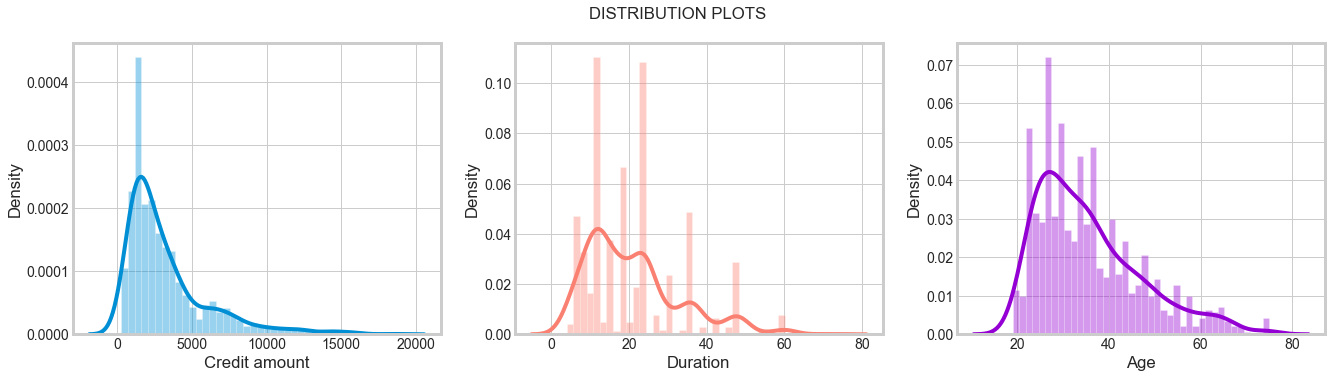

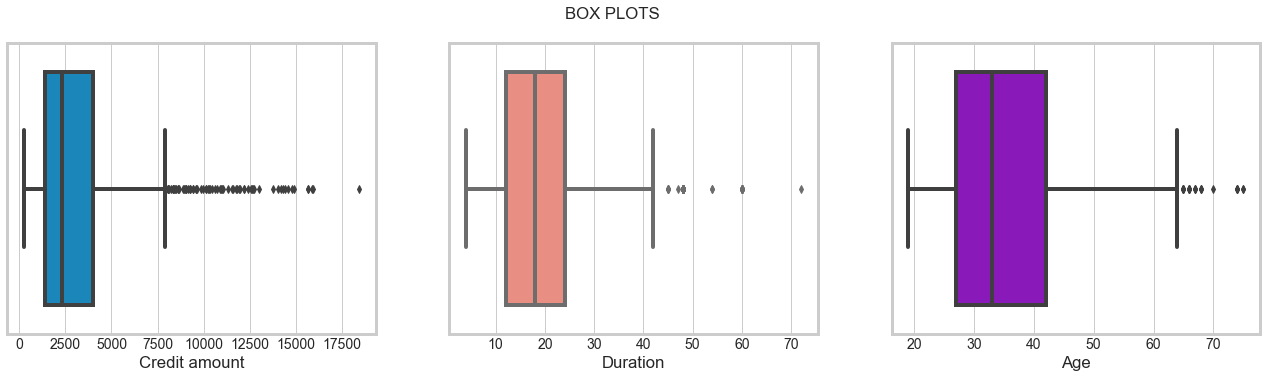

In [7]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS')
sns.distplot(df['Credit amount'], bins=40, ax=ax[0]);
sns.distplot(df['Duration'], bins=40, ax=ax[1], color='salmon');
sns.distplot(df['Age'], bins=40, ax=ax[2], color='darkviolet');

fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('BOX PLOTS')
sns.boxplot(df['Credit amount'], ax=ax[0]);
sns.boxplot(df['Duration'], ax=ax[1], color='salmon');
sns.boxplot(df['Age'], ax=ax[2], color='darkviolet');

### INSIGHTS
---
* Most of the credit cards have an amount of 1500 - 4000
* The Credit amount is positively skewed, So the samples are dispersed

#### COUNTPLOTS (SEX & RISK FACTOR)

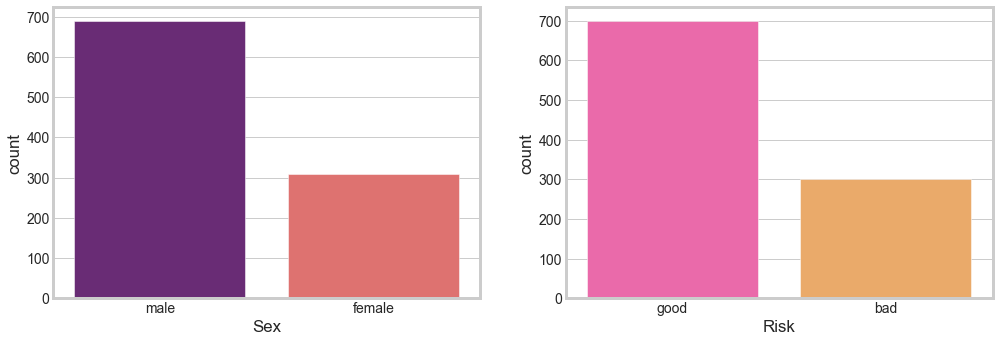

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.countplot(df['Sex'], ax=ax[0], palette='magma');
sns.countplot(df.Risk, ax=ax[1], palette='spring');

In [9]:
#Show basic stats
df[['Age', 'Duration', 'Credit amount']].describe()

,Age,Duration,Credit amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


### BIVARIATE ANALYSIS

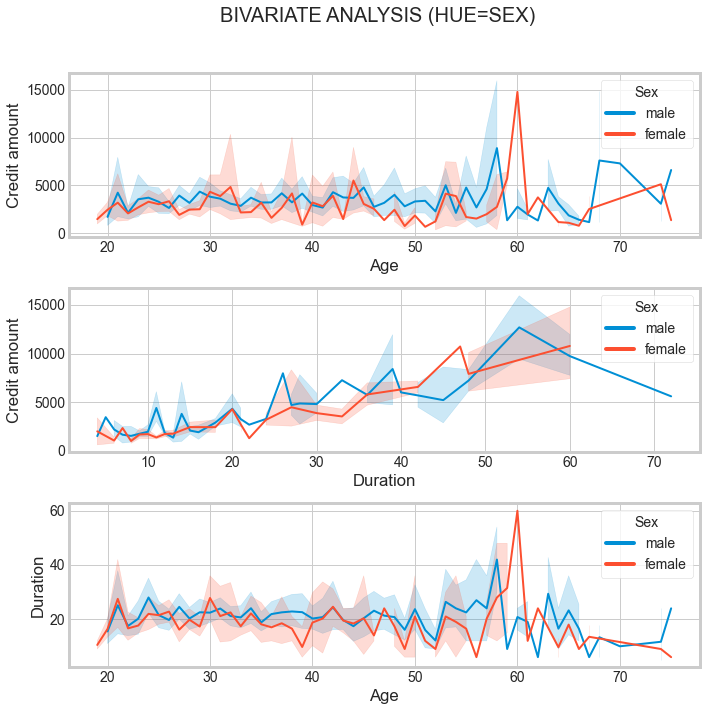

In [10]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=SEX)', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='Age', y='Duration', hue='Sex', lw=2, ax=ax[2]);


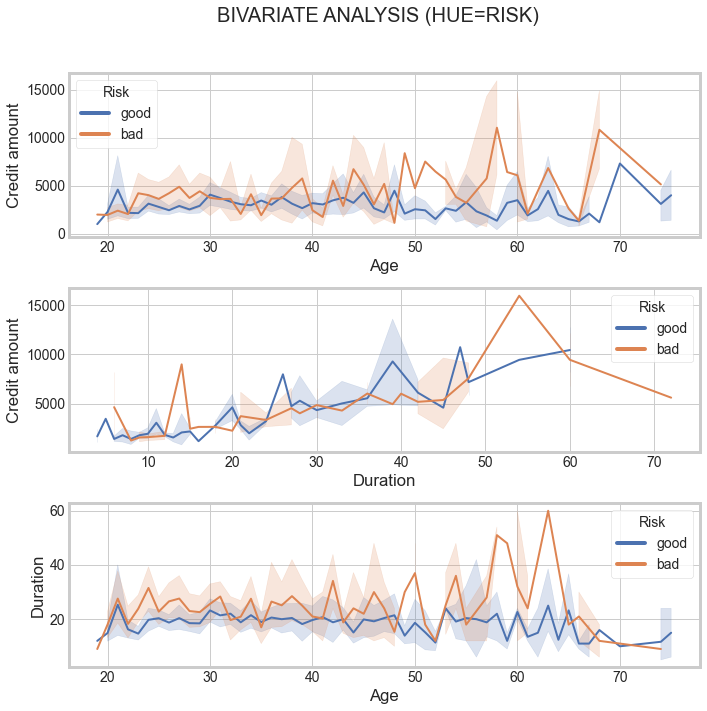

In [11]:
ig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=RISK)', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Risk', lw=2, ax=ax[0], palette='deep');
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Risk', lw=2, ax=ax[1], palette='deep');
sns.lineplot(data=df, x='Age', y='Duration', hue='Risk', lw=2, ax=ax[2], palette='deep');

### INSIGHTS
---
* There is a linear relationship between Duration and Creadit Amount, Which makes sense because usually, people take bigger credits for longer periods. 
* The trend Between Age and Credit amount is not clear.

### PAIRPLOT TO VISUALIZE FEATURES WITH LINEAR RELATIONSHIP

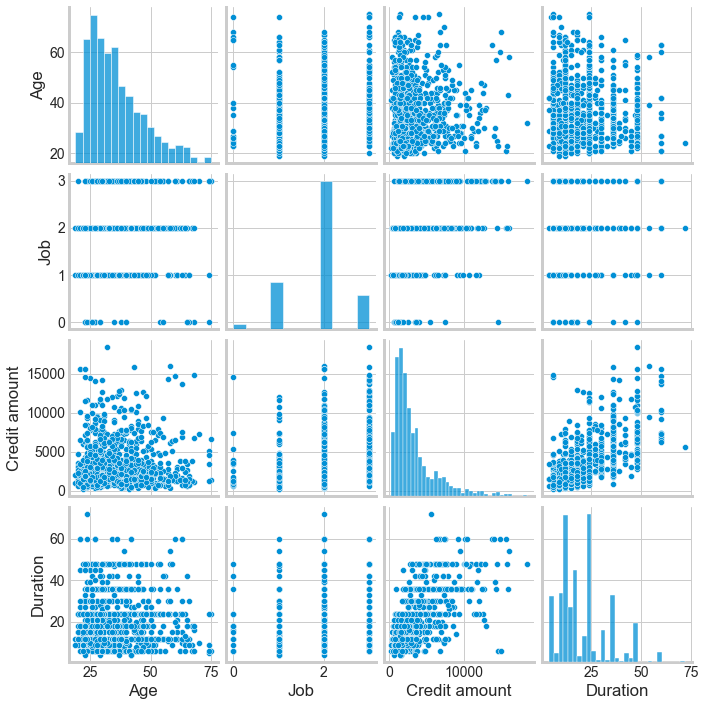

In [12]:
sns.pairplot(df);

### SAVING ACCOUNT ANALYSIS

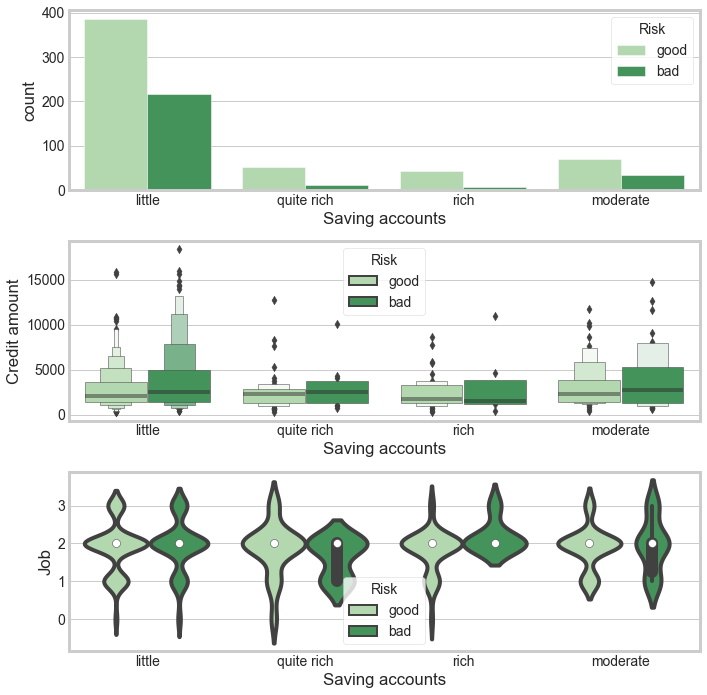

In [13]:
fig, ax =plt.subplots(3,1,figsize=(10,10))
plt.tight_layout(2)

sns.countplot(df['Saving accounts'], hue=df.Risk, ax=ax[0], palette='Greens');
sns.boxenplot(df['Saving accounts'], df['Credit amount'], hue=df.Risk, ax=ax[1], palette='Greens');
sns.violinplot(df['Saving accounts'], df['Job'], hue=df.Risk, ax=ax[2], palette='Greens');

#### SHOW BASIC STATS PER SAVING ACCOUNT

In [14]:
df.groupby('Saving accounts')[['Duration', 'Job', 'Credit amount']].describe().T

Saving accounts            little      moderate    quite rich          rich
Duration      count    603.000000    103.000000     63.000000     48.000000
              mean      20.441128     22.737864     19.031746     18.312500
              std       11.741163     13.776907     11.181737      8.550616
              min        4.000000      6.000000      6.000000      6.000000
              25%       12.000000     12.000000     12.000000     12.000000
              50%       18.000000     21.000000     15.000000     18.000000
              75%       24.000000     27.000000     24.000000     24.000000
              max       60.000000     72.000000     48.000000     48.000000
Job           count    603.000000    103.000000     63.000000     48.000000
              mean       1.903814      1.912621      1.809524      1.854167
              std        0.670227      0.595848      0.668584      0.545371
              min        0.000000      1.000000      0.000000      0.000000
              25%        2.000000      2.000000      2.000000      2.000000
              50%        2.000000      2.000000      2.000000      2.000000
              75%        2.000000      2.000000      2.000000      2.000000
              max        3.000000      3.000000      3.000000      3.000000
Credit amount count    603.000000    103.000000     63.000000     48.000000
              mean    3187.832504   3384.038835   2572.111111   2573.395833
              std     2787.683344   2874.944081   2208.532144   2174.447553
              min      276.000000    362.000000    338.000000    250.000000
              25%     1365.000000   1413.500000   1260.000000   1284.000000
              50%     2238.000000   2463.000000   2326.000000   1587.000000
              75%     3954.000000   4145.000000   2906.500000   3359.750000
              max    18424.000000  14782.000000  12749.000000  10961.000000

### ANALYSIS BY CREDIT CARD PURPOSE

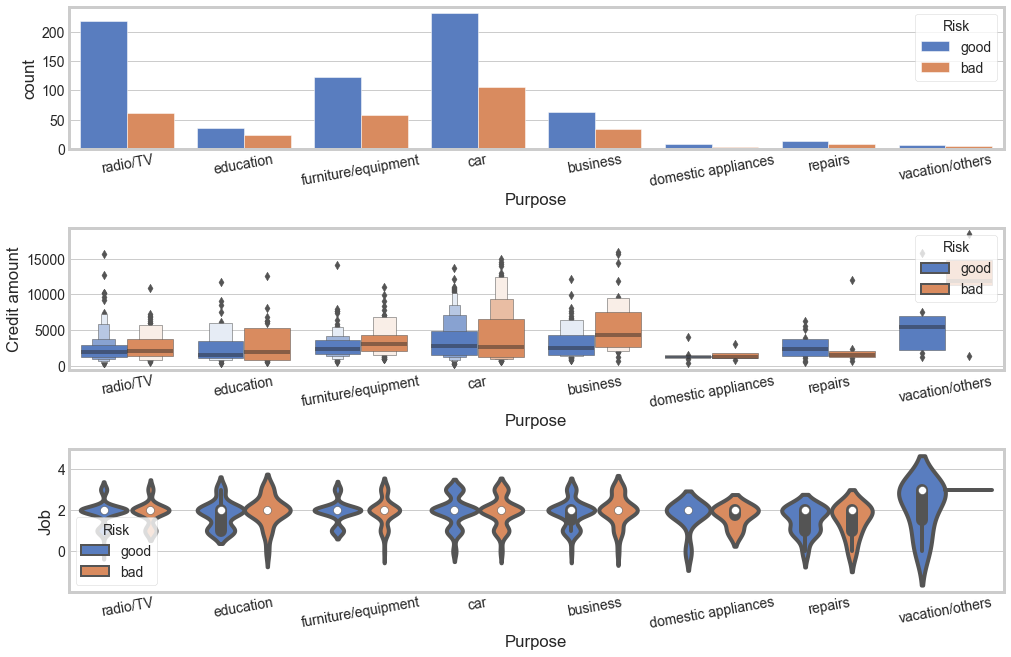

In [15]:
fig, ax =plt.subplots(3,1,figsize=(15,10))
plt.tight_layout(4)

for i in range(3):
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=10)


sns.countplot(df['Purpose'], hue=df.Risk, ax=ax[0], palette='muted');
sns.boxenplot(df['Purpose'], df['Credit amount'], hue=df.Risk, ax=ax[1], palette='muted');
sns.violinplot(df['Purpose'], df['Job'], hue=df.Risk, ax=ax[2], palette='muted');

### PER HOUSING

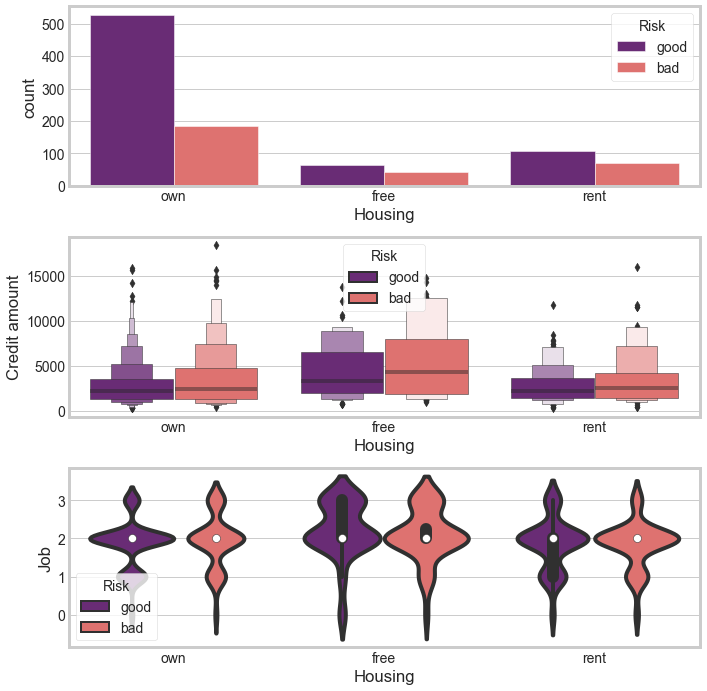

In [16]:
fig, ax =plt.subplots(3,1,figsize=(10,10))
plt.tight_layout(2)

sns.countplot(df['Housing'], hue=df.Risk, ax=ax[0], palette='magma');
sns.boxenplot(df['Housing'], df['Credit amount'], hue=df.Risk, ax=ax[1], palette='magma');
sns.violinplot(df['Housing'], df['Job'], hue=df.Risk, ax=ax[2], palette='magma');

## DATA PREPROCESSING
---

In [8]:
# replace null values with unknown
df= df.fillna('unknown')

In [9]:
#check the null values again
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [10]:
#drop the unnamed feature
#df.drop('Unnamed: 0', axis=1, inplace=True)
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [11]:
#labelencode the categorical features
for i, cat in enumerate(categorical_features):
    df[cat] = LabelEncoder().fit_transform(df[cat])

In [12]:
#show new df
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,3,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


### NORMALIZE THE NUMERIC FEATURES

#### APPLYING LOG TRANSFORMATION

In [13]:
num_df = df[['Age', 'Duration', 'Credit amount']]
num_df = np.log(num_df)

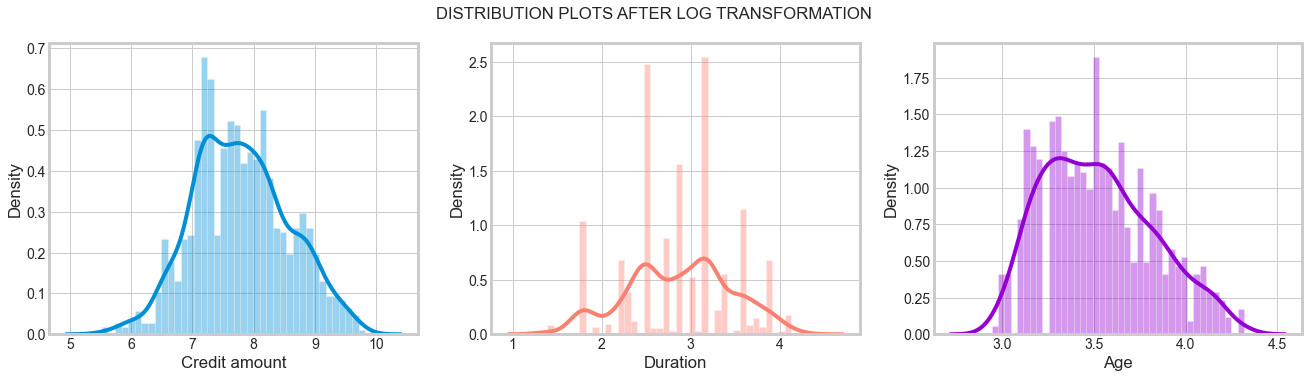

In [14]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS AFTER LOG TRANSFORMATION')
sns.distplot(num_df['Credit amount'], bins=40, ax=ax[0]);
sns.distplot(num_df['Duration'], bins=40, ax=ax[1], color='salmon');
sns.distplot(num_df['Age'], bins=40, ax=ax[2], color='darkviolet');

#### STANDARDSCALING

In [15]:
scaler = StandardScaler()
num_df_scaled = scaler.fit_transform(num_df)

In [16]:
#show new values
print(num_df_scaled.shape)
num_df_scaled

(1000, 3)


array([[ 2.27100592, -1.86486906, -0.933901  ],
       [-1.44615223,  1.7083687 ,  1.16304581],
       [ 1.22669602, -0.67378981, -0.1815588 ],
       ...,
       [ 0.37810951, -0.67378981, -1.4161991 ],
       [-1.29778048,  1.59746802, -0.34591111],
       [-0.76258638,  1.59746802,  0.82450846]])

## CLUSTERING
---

### K-MEANS

#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS

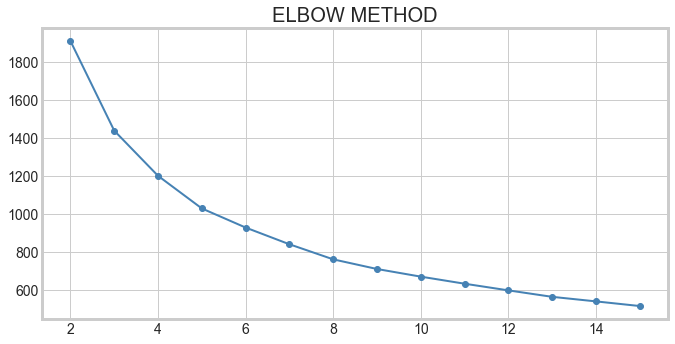

In [26]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(num_df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2, color='steelblue');

#### ALTERNATIVE METHOD: SILHOUTE SCORE WITH RANDOM SAMPLING

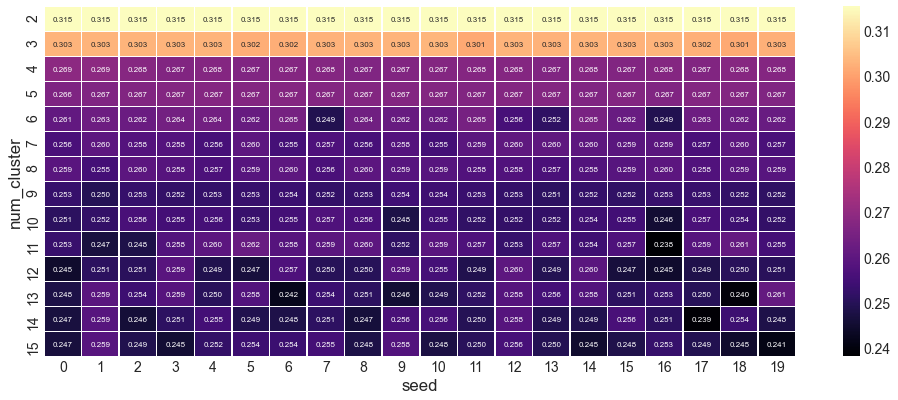

In [27]:
results = []

for i in range(2,16):
    for r in range(20):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(num_df_scaled)
        sil_ave = silhouette_score(num_df_scaled, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8});

* The scores of 2,3,4 and 5 are pretty stable, Let's pick a number of cluster from that range.

#### AT 3 NUMBER OF CLUSTERS

In [28]:
km = KMeans(n_clusters=3, random_state=0)
clusters = km.fit_predict(num_df_scaled)

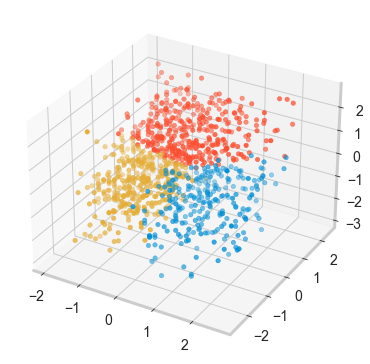

In [29]:
#show a 3D plot of clusters
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(num_df_scaled[clusters ==i,0], num_df_scaled[clusters ==i,1], num_df_scaled[clusters ==i,2])
    


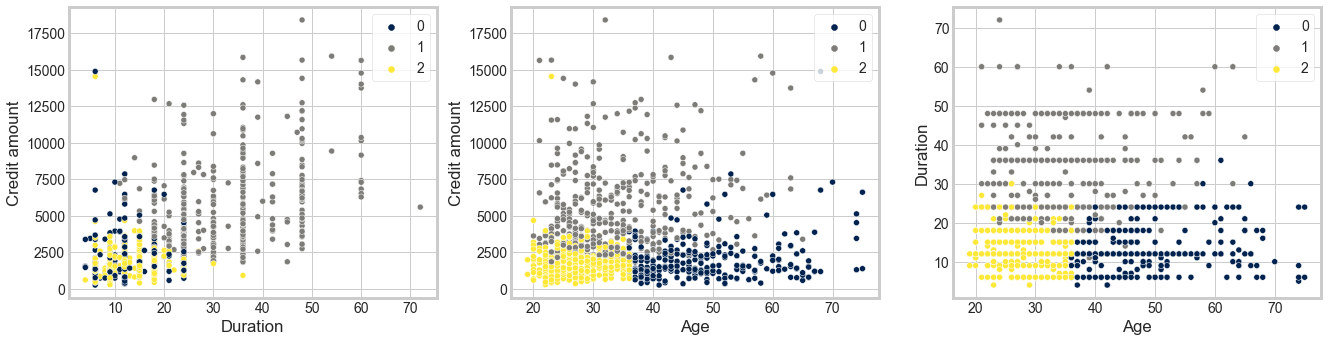

In [30]:
fig, ax  = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(df['Duration'], df['Credit amount'], hue=clusters, ax=ax[0], palette='cividis');
sns.scatterplot(df['Age'], df['Credit amount'], hue=clusters, ax=ax[1], palette='cividis');
sns.scatterplot(df['Age'], df['Duration'], hue=clusters, ax=ax[2], palette='cividis');

#### LET'S CREATE A DATAFRAME TO SUMMARIZE THE RESULT

In [31]:
df_clustered = df[['Age', 'Duration', 'Credit amount']]
df_clustered['cluster'] = clusters

In [32]:
df_clustered.groupby('cluster').mean()

,Age,Duration,Credit amount
cluster,,,
0,48.691120,13.918919,1979.745174
1,34.042667,32.224000,5665.384000
2,27.784153,14.245902,1732.199454


* Cluster 0 are the older customers.
* Cluster 1 are the middle-Aged customers.
* Cluster 2 are the younger customers.

## PREDICTIVE MODELLING
---

In [17]:
num_df_scaled = pd.DataFrame(num_df_scaled, columns=['Age', 'Duration', 'Credit Amount'])
cat_df = df[categorical_features]

data = pd.concat([cat_df, num_df_scaled], axis=1)

In [18]:
#show new dataframe
data.head()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Risk,Age,Duration,Credit Amount
0,1,2,1,4,0,5,1,2.271006,-1.864869,-0.933901
1,0,2,1,0,1,5,0,-1.446152,1.708369,1.163046
2,1,1,1,0,3,3,1,1.226696,-0.673790,-0.181559
3,1,2,0,0,0,4,1,0.942455,1.478913,1.525148
4,1,2,0,0,0,1,0,1.488620,0.517289,0.904743


### XGBOOST MODEL

#### SPLIT THE DATA

In [44]:
x = data.drop('Risk', axis=1)
y = data['Risk']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)

print('xtrain shape: ', x_train.shape)
print('xtest shape: ', x_test.shape)
print('ytrain shape: ', y_train.shape)
print('ytest shape: ', y_test.shape)


xtrain shape:  (800, 9)
xtest shape:  (200, 9)
ytrain shape:  (800,)
ytest shape:  (200,)


#### HYPERPARAMETER TUNING

In [45]:
#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=25) #25 iterations

In [46]:
rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=N

#### PREDICT THE TEST DATA

In [47]:
predictions = rs.predict(x_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.41      0.52        69
           1       0.75      0.92      0.83       131

    accuracy                           0.74       200
   macro avg       0.74      0.66      0.67       200
weighted avg       0.74      0.74      0.72       200



### PLOTTING ROC CURVE

In [48]:
def plot_roc(X, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

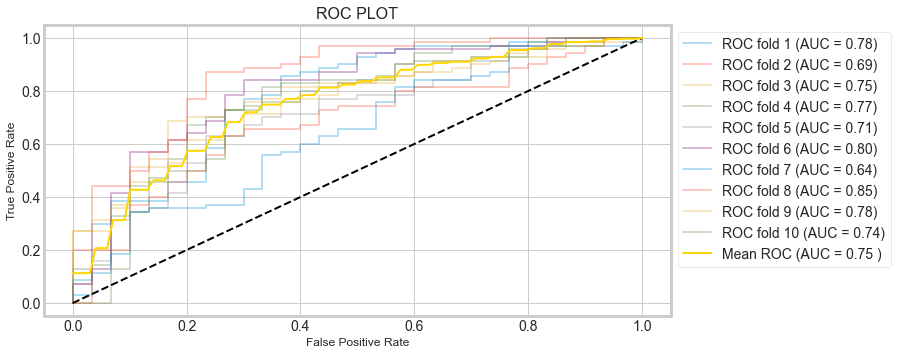

In [49]:
xgb_model = XGBClassifier()
xgb_model.set_params(**rs.best_params_)

plot_roc(x,y, xgb_model, n_splits=10)

## Fairness

In [19]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [20]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [21]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [22]:
data

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Risk,Age,Duration,Credit Amount
0,1,2,1,4,0,5,1,2.271006,-1.864869,-0.933901
1,0,2,1,0,1,5,0,-1.446152,1.708369,1.163046
2,1,1,1,0,3,3,1,1.226696,-0.673790,-0.181559
3,1,2,0,0,0,4,1,0.942455,1.478913,1.525148
4,1,2,0,0,0,1,0,1.488620,0.517289,0.904743
...,...,...,...,...,...,...,...,...,...,...
995,0,1,1,0,3,4,1,-0.301466,-0.673790,-0.424376
996,1,3,1,0,0,1,1,0.549317,0.900731,0.604255
997,1,2,1,0,3,5,1,0.378110,-0.673790,-1.416199
998,1,2,0,0,0,5,0,-1.297780,1.597468,-0.345911


In [23]:
#print(X)


#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]
dataset_orig = StandardDataset(df,
                                  label_name='Risk',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[0],
                                  privileged_classes=[[1]])

#metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
#                                             unprivileged_groups=unprivileged_groups,
#                                             privileged_groups=privileged_groups)
#display(Markdown("#### Original training dataset"))
#print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


In [24]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.074801


In [25]:
xgb_model = XGBClassifier()
xgb_model.set_params(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None,
                gamma=1.000000709716543, gpu_id=None, importance_type='gain',
                interaction_constraints=None, learning_rate=0.28559175093174183,
                max_delta_step=None, max_depth=5, min_child_weight=8,
                monotone_constraints=None, n_estimators=142, n_jobs=4,
                num_parallel_tree=None, random_state=None, reg_alpha=None,
                reg_lambda=None, scale_pos_weight=None, subsample=None,
                tree_method=None, validate_parameters=None, verbosity=None)

from sklearn.svm import SVC


rf = RandomForestClassifier()

models = []
models.append(('XGB', xgb_model))
models.append(('RF', rf))
models.append(('SVM', SVC(gamma='auto', probability = True)))

In [26]:
final_metrics = []
accuracy = []
f1= []
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier


for i in range(0,20):
    
    data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
    print(i)
    X_train = data_orig_train.features
    y_train = data_orig_train.labels.ravel()

    X_test = data_orig_test.features
    y_test = data_orig_test.labels.ravel()
    model = VotingClassifier(estimators=models, voting='soft')
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)

    
element_wise_std =  np.std(final_metrics, 0, ddof=1)
print("STD " + str(element_wise_std))
final_metrics = list(map(mean, zip(*final_metrics)))
accuracy = mean(accuracy)
f1 = mean(f1)
final_metrics[4] = np.log(final_metrics[4])
print(final_metrics)
print(sum(final_metrics[1:]))
print(accuracy)
print(f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
STD [5.91607978 0.04257123 0.08540839 0.04811832 0.46029521 0.03123386]
[9.5, 0.05795069519042129, 0.11264960659293226, 0.07218816183896694, 0.43704867498866407, 0.2558450084703145]
0.935682147081299
0.7438333333333333
0.8365758402478121


In [38]:
data_orig_train = pd.read_pickle('../../Results/VotingClassifier/3-bank-credit-data-clustering-modelling_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/VotingClassifier/3-bank-credit-data-clustering-modelling_Test.pkl')
#model.estimators

In [42]:
import ipynbname
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import pickle

#data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
estimators = models


model = VotingClassifier(estimators=models)

mdl = model.fit(X_train, y_train)

#with open('../../Results/VotingClassifier/' + nb_fname + '.pkl', 'wb') as f:
#    pickle.dump(mdl, f)

#with open('../../Results/VotingClassifier/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_train, f) 
    
#with open('../../Results/VotingClassifier/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_test, f) 

In [61]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    model = VotingClassifier(estimators=list_estimators, voting='soft')
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)        
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [66]:
f = model.predict_proba(X_test)[:,0].round(2)
print(f)
np.mean(f)

[0.17 0.42 0.43 0.13 0.57 0.22 0.6  0.2  0.24 0.26 0.53 0.15 0.33 0.59
 0.43 0.52 0.4  0.18 0.16 0.64 0.28 0.15 0.12 0.2  0.38 0.32 0.61 0.27
 0.61 0.26 0.52 0.32 0.51 0.27 0.16 0.33 0.17 0.23 0.3  0.2  0.25 0.44
 0.17 0.24 0.18 0.4  0.65 0.15 0.44 0.56 0.18 0.42 0.18 0.36 0.25 0.52
 0.22 0.19 0.16 0.22 0.31 0.28 0.4  0.52 0.51 0.18 0.57 0.25 0.35 0.15
 0.17 0.49 0.23 0.27 0.2  0.15 0.58 0.16 0.13 0.16 0.22 0.47 0.24 0.13
 0.27 0.21 0.24 0.23 0.27 0.14 0.14 0.44 0.52 0.26 0.16 0.41 0.23 0.66
 0.17 0.42 0.54 0.22 0.64 0.47 0.16 0.16 0.41 0.29 0.14 0.24 0.21 0.52
 0.52 0.16 0.14 0.13 0.42 0.51 0.27 0.49 0.2  0.13 0.4  0.29 0.33 0.16
 0.17 0.6  0.46 0.19 0.33 0.44 0.21 0.34 0.37 0.16 0.36 0.32 0.13 0.22
 0.19 0.67 0.45 0.45 0.55 0.52 0.24 0.18 0.14 0.19 0.34 0.23 0.37 0.28
 0.15 0.46 0.37 0.26 0.15 0.3  0.27 0.28 0.45 0.55 0.19 0.28 0.14 0.2
 0.43 0.2  0.21 0.62 0.08 0.17 0.21 0.15 0.17 0.62 0.55 0.44 0.15 0.37
 0.32 0.13 0.12 0.33 0.31 0.37 0.47 0.15 0.2  0.15 0.25 0.45 0.14 0.35
 0.2  0

0.31350000000000006

In [62]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
#final_result.to_csv('../../Results/VotingClassifier/' + nb_fname + '.csv')
final_result

,classifier,T0,T1,T2
accuracy,0.740000,0.720000,0.750000,0.740000
f1,0.831897,0.809091,0.832215,0.831897
statistical_parity_difference,0.144941,0.141393,0.147356,0.144941
equal_opportunity_difference,0.027044,0.066038,0.047170,0.027044
average_abs_odds_difference,0.105655,0.114354,0.112055,0.105655
disparate_impact,0.761803,0.518422,0.591316,0.761803
theil_index,0.228587,0.204099,0.194039,0.228587
